# Prepare libraries

In [ ]:
%%writefile requirements_clip.txt
torch==1.13.1
torchvision==0.14.1
git+https://github.com/openai/CLIP.git

Overwriting requirements_clip.txt


In [ ]:
!pip install -q -r requirements_clip.txt

# Prepare datasets

In [ ]:
!gdown -q 1Do8SXKm4rmXW-phHlejV-udLfhSyYgKk

In [ ]:
!rm -rf animals10small/
!unzip -q animals10small.zip

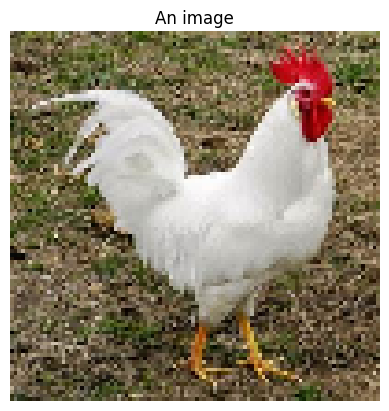

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


def show_image(image, title="An image", figsize=(3,3)):
  plt.figure()
  if image.ndim == 2:
    plt.imshow(image, cmap="gray")
  elif image.ndim == 3:
    plt.imshow(image)
  else:
    raise Exception("Invalid image dimension")

  plt.axis("off")
  plt.title(title)
  plt.show()

path = "animals10small/data"
files = ["chicken/10.jpeg",
         "chicken/100.jpeg",
         "cat/1.jpeg",
         "cat/10.jpeg"]
fnames = [os.path.join(path, fn) for fn in files]
rgb = [cv2.imread(fn, 1) for fn in fnames]
rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in rgb]
rgb = [cv2.resize(im, (100, 100)) for im in rgb]

show_image(rgb[0])

# Extract features

In [ ]:
#!/usr/bin/env python3
"""
CLIP Feature Extractors
Using CLIP model to extract features for images and text
"""

import torch
import clip
import numpy as np
from PIL import Image
from typing import List, Union
import warnings
warnings.filterwarnings('ignore')

class CLIPFeatureExtractor:
    """Class to extract features using CLIP model"""

    def __init__(self, model_name: str = "ViT-B/32", device: str = None):
        """
        Initialize CLIP model

        Args:
            model_name: CLIP model name ('ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64')
            device: Device to run model ('cuda', 'cpu', or None for auto selection)
        """
        self.model_name = model_name

        # Auto select device
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

        print(f"Loading CLIP model: {model_name}")
        print(f"Using device: {self.device}")

        # Load model and preprocessor
        self.model, self.preprocess = clip.load(model_name, device=self.device)

        # Get feature dimensions
        with torch.no_grad():
            dummy_text = clip.tokenize(["dummy text"]).to(self.device)
            dummy_image = torch.randn(1, 3, 224, 224).to(self.device)

            text_features = self.model.encode_text(dummy_text)
            image_features = self.model.encode_image(dummy_image)

            self.text_feature_dim = text_features.shape[1]
            self.image_feature_dim = image_features.shape[1]

        print(f"Text feature dimension: {self.text_feature_dim}")
        print(f"Image feature dimension: {self.image_feature_dim}")

    def extract_image_features(self, images: np.ndarray) -> np.ndarray:
        """
        Extract features from image batch

        Args:
            images: numpy array with shape (N, C, H, W)
                   - N: number of images
                   - C: number of channels (usually 3 for RGB)
                   - H, W: height and width

        Returns:
            features: numpy array with shape (N, D) where D is feature dimension
        """
        print(f"Extracting features from {images.shape[0]} images...")

        # Convert numpy array to tensor
        if not isinstance(images, torch.Tensor):
            images = torch.from_numpy(images).float()

        # Ensure images have correct format (N, C, H, W)
        if images.dim() != 4:
            raise ValueError(f"Images must have 4 dimensions (N, C, H, W), got: {images.shape}")

        if images.shape[1] != 3:
            raise ValueError(f"Images must have 3 channels (RGB), got: {images.shape[1]} channels")

        # Move to device
        images = images.to(self.device)

        # Normalize images to range [0, 1] if needed
        if images.max() > 1.0:
            images = images / 255.0

        # Resize images to CLIP standard size (224x224)
        if images.shape[2] != 224 or images.shape[3] != 224:
            images = torch.nn.functional.interpolate(
                images, size=(224, 224), mode='bilinear', align_corners=False
            )

        # Extract features
        with torch.no_grad():
            features = self.model.encode_image(images)

            # Normalize features
            features = features / features.norm(dim=-1, keepdim=True)

        # Convert to numpy and move to CPU
        features_np = features.cpu().numpy()

        print(f"Completed! Features shape: {features_np.shape}")
        return features_np

    def extract_text_features(self, texts: List[str]) -> np.ndarray:
        """
        Extract features from text list

        Args:
            texts: List containing M texts (strings)

        Returns:
            features: numpy array with shape (M, D) where D is feature dimension
        """
        print(f"Extracting features from {len(texts)} texts...")

        if not isinstance(texts, list):
            raise ValueError("Input must be a list containing texts")

        if len(texts) == 0:
            raise ValueError("Text list cannot be empty")

        # Tokenize texts
        text_tokens = clip.tokenize(texts, truncate=True).to(self.device)

        # Extract features
        with torch.no_grad():
            features = self.model.encode_text(text_tokens)

            # Normalize features
            features = features / features.norm(dim=-1, keepdim=True)

        # Convert to numpy and move to CPU
        features_np = features.cpu().numpy()

        print(f"Completed! Features shape: {features_np.shape}")
        return features_np

# Convenience functions for direct use
def extract_image_features(images: np.ndarray, model_name: str = "ViT-B/32", device: str = None) -> np.ndarray:
    """
    Convenience function to extract image features

    Args:
        images: numpy array with shape (N, C, H, W)
        model_name: CLIP model name
        device: Device to run model

    Returns:
        features: numpy array with shape (N, D)
    """
    extractor = CLIPFeatureExtractor(model_name=model_name, device=device)
    return extractor.extract_image_features(images)

def extract_text_features(texts: List[str], model_name: str = "ViT-B/32", device: str = None) -> np.ndarray:
    """
    Convenience function to extract text features

    Args:
        texts: List containing M texts
        model_name: CLIP model name
        device: Device to run model

    Returns:
        features: numpy array with shape (M, D)
    """
    extractor = CLIPFeatureExtractor(model_name=model_name, device=device)
    return extractor.extract_text_features(texts)

# Demo and test functions
def demo_image_features():
    """Demo image feature extraction with fake data"""
    print("=== DEMO IMAGE FEATURE EXTRACTION ===")

    # Create fake image data (5 RGB images 256x256)
    batch_size = 5
    height, width = 256, 256
    fake_images = np.random.randint(0, 256, (batch_size, 3, height, width), dtype=np.uint8)

    print(f"Input images shape: {fake_images.shape}")

    # Extract features
    features = extract_image_features(fake_images)

    print(f"Output features shape: {features.shape}")
    print(f"Features sample (first image): {features[0][:10]}")  # Print first 10 values

    return features

def demo_text_features():
    """Demo text feature extraction"""
    print("\n=== DEMO TEXT FEATURE EXTRACTION ===")

    # Sample text list
    sample_texts = [
        "A beautiful sunset over the mountains",
        "A cat sitting on a windowsill",
        "People walking in a busy street",
        "A delicious pizza with cheese and tomatoes",
        "A modern building with glass windows"
    ]

    print(f"Input texts ({len(sample_texts)} texts):")
    for i, text in enumerate(sample_texts):
        print(f"  {i+1}. {text}")

    # Extract features
    features = extract_text_features(sample_texts)

    print(f"\nOutput features shape: {features.shape}")
    print(f"Features sample (first text): {features[0][:10]}")  # Print first 10 values

    return features

def demo_similarity():
    """Demo similarity calculation between image and text"""
    print("\n=== DEMO IMAGE-TEXT SIMILARITY ===")

    # Create extractor
    extractor = CLIPFeatureExtractor()

    # Create fake image
    fake_image = np.random.randint(0, 256, (1, 3, 224, 224), dtype=np.uint8)

    # Description texts
    texts = [
        "a photo of a cat",
        "a photo of a dog",
        "a photo of a car",
        "a photo of a house"
    ]

    # Extract features
    image_features = extractor.extract_image_features(fake_image)
    text_features = extractor.extract_text_features(texts)

    # Calculate similarity
    similarities = np.dot(image_features, text_features.T).flatten()

    print("Similarity scores between image and descriptions:")
    for text, sim in zip(texts, similarities):
        print(f"  '{text}': {sim:.4f}")

    # Find best matching description
    best_match_idx = np.argmax(similarities)
    print(f"\nBest matching description: '{texts[best_match_idx]}' (score: {similarities[best_match_idx]:.4f})")

def main():
    """Main function to demo all functionality"""
    print("🚀 CLIP FEATURE EXTRACTORS DEMO")
    print("=" * 50)

    try:
        # Demo image feature extraction
        image_features = demo_image_features()

        # Demo text feature extraction
        text_features = demo_text_features()

        # Demo similarity calculation
        demo_similarity()

        print("\n" + "=" * 50)
        print("✅ CLIP FEATURE EXTRACTORS DEMO COMPLETED")
        print(f"📊 Image features shape: {image_features.shape}")
        print(f"📊 Text features shape: {text_features.shape}")

    except Exception as e:
        print(f"❌ Error: {e}")
        print("Make sure CLIP is installed: pip install git+https://github.com/openai/CLIP.git")

if __name__ == "__main__":
    main()


🚀 CLIP FEATURE EXTRACTORS DEMO
=== DEMO IMAGE FEATURE EXTRACTION ===
Input images shape: (5, 3, 256, 256)
Loading CLIP model: ViT-B/32
Using device: cpu
Text feature dimension: 512
Image feature dimension: 512
Extracting features from 5 images...
Completed! Features shape: (5, 512)
Output features shape: (5, 512)
Features sample (first image): [ 0.004605   -0.00662657  0.01314521 -0.03096022 -0.00359882 -0.03261875
  0.00772292  0.10060164  0.03656151  0.00882995]

=== DEMO TEXT FEATURE EXTRACTION ===
Input texts (5 texts):
  1. A beautiful sunset over the mountains
  2. A cat sitting on a windowsill
  3. People walking in a busy street
  4. A delicious pizza with cheese and tomatoes
  5. A modern building with glass windows
Loading CLIP model: ViT-B/32
Using device: cpu
Text feature dimension: 512
Image feature dimension: 512
Extracting features from 5 texts...
Completed! Features shape: (5, 512)

Output features shape: (5, 512)
Features sample (first text): [-0.01282188  0.00744312  

# Demo of using features

In [ ]:
import os

base_path = "./animals10small/data"
class_names = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

print(class_names)

['dog', 'spider', 'sheep', 'cat', 'elephant', 'squirrel', 'chicken', 'cow', 'butterfly', 'horse']


In [ ]:
batch_images = np.stack(rgb)
batch_images = batch_images.transpose(0, 3, 1, 2)
batch_images.shape

(4, 3, 100, 100)

In [ ]:
labels = [
    "a photo of a chicken",
    "a photo of a dog",
    "a photo of a cat",
    "a photo of a horse"
]


In [ ]:

"""Demo similarity calculation between image and text"""
print("\n=== DEMO IMAGE-TEXT SIMILARITY ===")

# Create extractor
extractor = CLIPFeatureExtractor()

# Extract features
image_features = extractor.extract_image_features(batch_images)
text_features = extractor.extract_text_features(class_names)





=== DEMO IMAGE-TEXT SIMILARITY ===
Loading CLIP model: ViT-B/32
Using device: cpu
Text feature dimension: 512
Image feature dimension: 512
Extracting features from 4 images...
Completed! Features shape: (4, 512)
Extracting features from 10 texts...
Completed! Features shape: (10, 512)


In [ ]:
# Calculate similarity
#similarities = np.dot(image_features, text_features.T)
similarities = np.einsum('nd,md->nm', image_features, text_features)
print(similarities.shape)


(4, 10)


In [ ]:

print("Similarity scores between image and descriptions:")
print(similarities)


Similarity scores between image and descriptions:
[[0.22555512 0.19527228 0.20955715 0.2065022  0.1782968  0.20355518
  0.28809196 0.23541613 0.18666823 0.2178749 ]
 [0.20681106 0.17757039 0.20714359 0.18935503 0.16551879 0.18567476
  0.2772681  0.2229433  0.16972063 0.20184082]
 [0.2312194  0.21973649 0.20698284 0.27209994 0.20666143 0.23782815
  0.23004861 0.22821184 0.19976854 0.22269253]
 [0.21240455 0.18342608 0.1887851  0.25481045 0.17114857 0.18504842
  0.20418441 0.19996895 0.17548898 0.18799196]]


In [ ]:

# Find best matching description
best_match_idx = np.argmax(similarities, axis=-1)
for idx, im_idx in enumerate(best_match_idx):
    print(f"  '{class_names[im_idx]}' (score: {similarities[idx, im_idx]:.4f})")

  'chicken' (score: 0.2881)
  'chicken' (score: 0.2773)
  'cat' (score: 0.2721)
  'cat' (score: 0.2548)


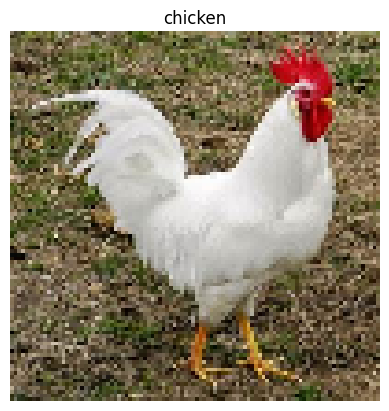

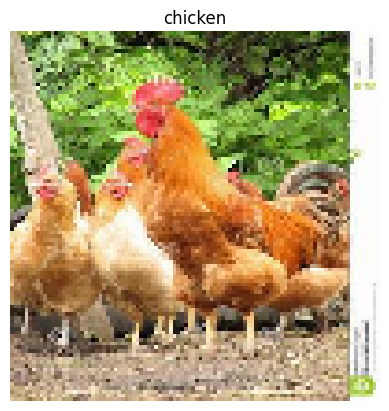

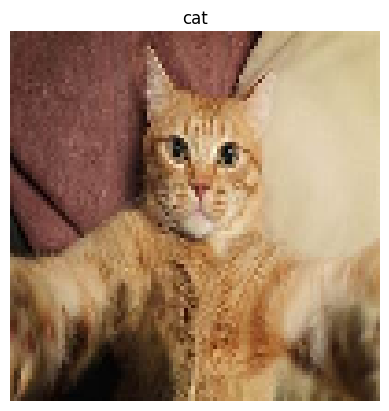

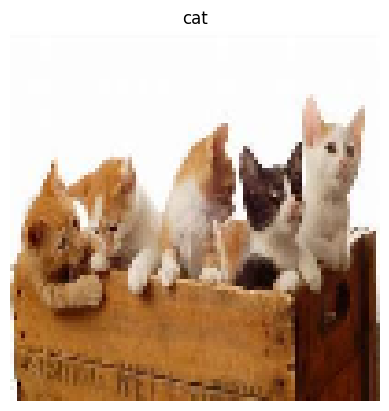

In [ ]:
for im_idx in range(batch_images.shape[0]):
  image = batch_images[im_idx].transpose(1, 2, 0)
  show_image(image, title=class_names[best_match_idx[im_idx]])
